## Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

## Importamos todas las librerías que vamos a usar en el proyecto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.utils import shuffle

## Cargamos los datos y analizamos la información.

In [2]:
churn = pd.read_csv('./datasets/Churn.csv')
churn.info()
print(churn.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    1563

<div class="alert alert-block alert-info">

Lo primero que observamos es que tenemos la colmna Ternure con valores auentes. Según la documentación la columna Tenure es el número de años que el cliente ha mantenido (o mantuvo) el depósito a plazo fijo activo. Por lo que los valores nulos significa que el cliente no tiene actualmente un depósito a plazo fijo, o nunca ha tenido uno. En otras palabras, no aplica o no se ha iniciado el conteo. Así que dado eso, vamos a rellenar con CERO esos nulos.

</br>
</b> <a class="tocSkip"></a>
</div>

In [3]:
# Se observa que hay valores nullos para la columna tenure


churn['Tenure'].fillna(0, inplace=True)

C:\Users\paste\AppData\Local\Temp\ipykernel_29000\2967904463.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  churn['Tenure'].fillna(0, inplace=True)


<div class="alert alert-block alert-info">

Por otro lado, detectamos tres columnas que no son categóricas y más que eso pueden meter ruido a nuestro modelo:
</br>
RowNumber: índice de cadena de datos
</br>
CustomerId: identificador de cliente único
</br>
Surname: apellido
</br>
Así que vamos a eliminar estas columnas.
</br>

Además, tenemos las columnas categóricas que sí son de interes, pero las vamos a transformar a características numéricas:
</br>
Geography: país de residencia
</br>
Gender: sexo
</b> <a class="tocSkip"></a>
</div>

In [4]:
# Se observa que las columnas RowNumber , CustomerId , Surname son identificadores SIN orden o significado categórico 
# Así qu elas vamos a eliminar para que no generen ruido en nuestro modelo

churn = churn.drop(['RowNumber','CustomerId','Surname'] , axis=1)

# Como hay columnas de tipo object, vamos a transformar las características a numéricas usando One-Hot Enconding

churn_ohe =  pd.get_dummies(churn, drop_first =True )

#churn_ohe.info()
#print(churn_ohe.head(10))

## Creamos nuestro conjunto de características y objetivo.

Usamos el Split para tener un conjunto de entrenamiento y un conjunto de validación con un 25% de datos.

In [5]:
# Creamos nuestro conjunto de entrenamiento

features = churn_ohe.drop('Exited', axis = 1)
target = churn_ohe['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

## Comenzamos a investigar diferentes modelos de entrenamiento.

<div class="alert alert-block alert-info">

Comenzamos con un Árbol de decisión, ya que hemos visto que este nos ha dado buenos resultados.
</br>
</b> <a class="tocSkip"></a>
</div>

In [6]:
#Con estos datos ya completmente numéricos, vamos a entrer un modelo para ir comparand las mejora al equilibrar las clases.

model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

#La matriz de confusión es:
print(confusion_matrix(target_valid, predicted_valid))

# se observa que aun tenenmos muchos erroes de Falsos positivos y falso negativos.

F1: 0.49640287769784175
[[1664  301]
 [ 259  276]]


<div class="alert alert-block alert-info">

Con este árbol de decisión obtenemos un F1 de 0.49, aun lejos de la meta y nuestra matriz de confusión nos dice que tenemos un buen margen de Verdaderos negativos (1664), pero también tenemos un alto número de Falso Positivos y no queremos eso.
</br>
</b> <a class="tocSkip"></a>
</div>

## Bosque de aleatorio

Como hemos los hemos visto en la práctica, un bosque aleatorio nos da buenos resultados y más si realizamos una búsqueda de profundidad en los hiperparámetros.

In [7]:
# utilizando diferente parámetros buscaremos el de mejor resultado para el árbol de decisión

# Configuración de incio 
best_accuracy = 0  
best_est = 0
best_depth = 0
# vamos a hacer una revión se los estimaciones desde el 10 al 100 en saltos de 10 en 10.
for est in range (10, 101, 10):
    # vamos hacer una revisión con una profundidad de 1 a 10
    for depth in range(1, 11):
        # Inicializamos el constructor del modelo con los parámetros del ciclo.
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        # Entrenamos el modelo
        model.fit(features_train, target_train)
        # obtenemos las predicciones del modelo entrenado
        predictions = model.predict(features_valid)
        
        accuracy = accuracy_score(target_valid, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_est = est
            best_depth = depth
print(f"La mejor exactitud en el conjunto de validación: {best_accuracy} para los n_estimators de {best_est} , depth={best_depth}.")

La mejor exactitud en el conjunto de validación: 0.858 para los n_estimators de 20 , depth=7.


In [8]:
# Usando los mejores resultados que es para los n_estimators de 20 , depth=7.

model = RandomForestClassifier(random_state = 12345, n_estimators = 20, max_depth = 7)
# Entrenamos el modelo
model.fit(features_train, target_train)
# obtenemos las predicciones del modelo entrenado
predictions = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

#La matriz de confusión es:
print(confusion_matrix(target_valid, predicted_valid))


F1: 0.49640287769784175
[[1664  301]
 [ 259  276]]


<div class="alert alert-block alert-info">

Con el bosque aleatorio, y con su mejores parámetros que dan la mejor precisión (0.858 para los n_estimators de 20 , depth=7), vamos a calcular su F1 que es de 0.49, que es igual que árbol de decisión, así que no obtuvimos gran mejoría al respecto, así que ahora vamos a analizar el balanceo.
</br>
</b> <a class="tocSkip"></a>
</div>

## Regresión Logística con balanceo


Comenzamos con lo mas simple, que sería usar la regresión logística y ponerle el hiperparámeto de "balanceado".

In [9]:
# Ahora usaems un balancelo en un modelo de regresión logítica

model = LogisticRegression(random_state=12345,class_weight='balanced' ,  solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))
#La matriz de confusión es:
print(confusion_matrix(target_valid, predicted_valid))


# No hay una mejora en lo abosoluto

F1: 0.46426312460468055
[[1286  679]
 [ 168  367]]


<div class="alert alert-block alert-info">

Con la regresión  logística balanceada no tuvimos ninguna mejora. 
</br>
</b> <a class="tocSkip"></a>
</div>

## Balancear las clases incrementando los "unos"

Vamos a repetir todas aquellas caracteríticas donde el cliente se ha ido. Es decir, vamos a incrementar el número de casos de esos clientes que se han ido de Beta Bank.

In [10]:
#Vamos a usar la tecnica para deducir el desequilibrio de clases...

# Función que dado las caracterisitcas y los targets, y un valor de repeticón.vamos a 
#incrmeneter nuetor numoes de ONES para tener un mejor balance.
def upsample(features_in, target_in, repeat):
    features_zeros = features_in[target_in == 0]
    features_ones = features_in[target_in == 1]
    target_zeros = target_in[target_in == 0]
    target_ones = target_in[target_in == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


In [11]:

features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)

model = RandomForestClassifier(random_state = 12345, n_estimators = 20, max_depth = 7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 con Bosque aleatorio:', f1_score(target_valid, predicted_valid))
#La matriz de confusión es:
print(confusion_matrix(target_valid, predicted_valid))


model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 con árbole de decisión:', f1_score(target_valid, predicted_valid))
#La matriz de confusión es:
print(confusion_matrix(target_valid, predicted_valid))


F1 con Bosque aleatorio: 0.6285714285714286
[[1636  329]
 [ 139  396]]
F1 con árbole de decisión: 0.4980694980694981
[[1722  243]
 [ 277  258]]


<div class="alert alert-block alert-info">

Ahora ya vemos una mejor significativa, se observa que al darle al modelo más casos donde se fueron lo clientes le ayudó a comprender mejor y más aun, ahora se nota una diferencia entre usar el bosque de decisión con los mejores hiperparátmetros, a usar un simple árbol de decisión.
</br>
Ya tenemos un valor F1 de 0.62 con el bosque aleatorio con n_estimators = 20, max_depth = 7.


</br>
</b> <a class="tocSkip"></a>
</div>

## Balancear las clases reduciendo los "ceros"

Ahora, en lugar de sobre cargar los datos, busquemos reducir los casos donde no se fue el cliente de Beta Bank. Con esto, en lugar de que sepa más de las causas de porque se van, lo que hacemos en quitar aleatoriamente más causas por las que se quedan.


In [12]:
# ahora vamos a intenentar con un submuetreo

## Función que reduce en fraction la cantidad de zeros de los datos
def downsample(features_in, target_in, fraction):
    features_zeros = features_in[target_in == 0]
    features_ones = features_in[target_in == 1]
    target_zeros = target_in[target_in == 0]
    target_ones = target_in[target_in == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled



In [13]:

features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.4
)

model = RandomForestClassifier(random_state = 12345, n_estimators = 20, max_depth = 7)
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))
#La matriz de confusión es:
print(confusion_matrix(target_valid, predicted_valid))

F1: 0.6387035271687321
[[1786  179]
 [ 200  335]]


<div class="alert alert-block alert-info">

Resulta que es mejor reducir los datos donde los clientes se quedan, en lugar de incrementar los datos donde los clientes se van.
</br>
Pareciera que para nuestro caso de estudio es mejor entender la fidelidad de nuestros clientes, en lugar las razones por las que se van.

</br>
Ahora, hemos  lugardo un valor F1 de 0.63 que ya es altamente aceptable.

</br>
</b> <a class="tocSkip"></a>
</div>

## Precisión de la curva ROC

Con nuestro mejor F1, ahora vamos a ver la precisión de nuestro modelo al rankear con uno (deja de ser cliente) y ver que en verdad estemos clasificando bien.


La métrica AUC-ROC es: 0.8607281634206083


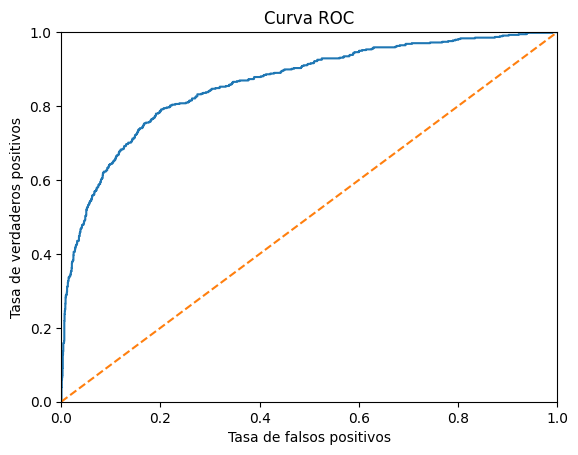

In [14]:
# ahora vamos a medor la precisión  de la curva ROC

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# Curva ROC para modelo aleatorio (parece una línea recta)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('La métrica AUC-ROC es:',auc_roc)


In [15]:
best_threshold = 0
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.01):
    predicted = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted)
    if score > best_f1:
        best_f1 = score
        best_threshold = threshold

print(f"Mejor threshold: {best_threshold:.2f} con F1: {best_f1:.4f}")



Mejor threshold: 0.49 con F1: 0.6417


## Conclusiones

Después de prepara y limpiar los datos, se observó que había un desequilibrio de clases lo que probocaba que bajos los diferentes modelos de entrenamiento, ninguno lograba comprender con buena precisión los datos.

Se revisóe sobrecargar el modelo y sub-cargar el modelo,siendo este último el de  mejores resultados. Lo que da a entender es que apra el nuestro caso de estudios, tener más clara la fidelidad de los clientes nos da mejores resultado para determinar si un cliente se va a dejar o no Beta Bank.

Nuestra métrica AUC-ROC nos dice que nuestro modelo final, un Bosque aleatorio con hiperparámetros de n_estimators = 20, max_depth = 7, obtenemos un 86% de probabilidad de rankear corréctamente a un cliente que se va a ir de Beta Bank, por encima a uno que no se va.